# The goal of a Transposed Convolution is to do the opposite of a regular Convolution, i.e., to upsample the input feature map to a desired larger size output feature map.

In [1]:
# Tensorflow / Keras
import tensorflow as tf # for building Neural Networks
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for assembling a Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Conv2D, Conv2DTranspose # for adding layers to our Neural Network
from tensorflow.keras.utils import plot_model # for plotting model diagram


# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version


# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib # for showing images
import matplotlib.pyplot as plt # for showing images
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

Tensorflow/Keras: 2.7.0
pandas: 1.3.4
numpy: 1.22.4
sklearn: 1.2.2
OpenCV: 4.8.0
matplotlib: 3.4.3
graphviz: 0.20.1


Next, we download, save and ingest Caltech 101 image data set. Note that I will only use images of pandas (Category = “panda”) in this example instead of an entire list of 101 categories.

At the same time, I prep the data and save images in two different resolutions:

64 x 64 pixels, which will be our low-res input data.
256 x 256 pixels, which will be our hi-res target data.

In [23]:
BASE_DIR = 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101'

In [24]:
CATEGORY = set(["panda"])

In [25]:
# Create two lists to contain image paths and image labels
ImagePaths=[]
for panda in CATEGORY:
    for image in list(os.listdir(ImgLocation+"/"+panda)):
        ImagePaths=ImagePaths+[ImgLocation+"/"+panda+"/"+image]

In [26]:
ImagePaths[0:10]

['C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0001.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0002.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0003.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0004.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0005.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0006.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0007.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_0008.jpg',
 'C:/Users/Admin/Machine Learning chapter 5/Deep Learning basics with Python/caltech-101/panda/image_000

In [27]:
# Load images and resize. We will need images in 64 x 64 and 256 x 256 pixels.
data_lowres=[]
data_hires=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    image_hires = cv2.resize(image, (256, 256))
    data_lowres.append(image_lowres)
    data_hires.append(image_hires)

In [28]:
#Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0
data_hires = np.array(data_hires, dtype="float") / 255.0

In [29]:
#Show data shape
print("Shape of whole data_lowres: ", data_lowres.shape)
print("Shape of whole data_hires: ", data_hires.shape)

Shape of whole data_lowres:  (38, 64, 64, 3)
Shape of whole data_hires:  (38, 256, 256, 3)


# 38 images of size 64-64 and 38 images of size 256-256

In [30]:
# ---- Create training and testing samples ---
X_train, X_test, Y_train, Y_test = train_test_split(data_lowres, data_hires, test_size=0.2, random_state=0)

# To better understand what data we are working with, let’s display a few low-res images that we will use as inputs. X-Train

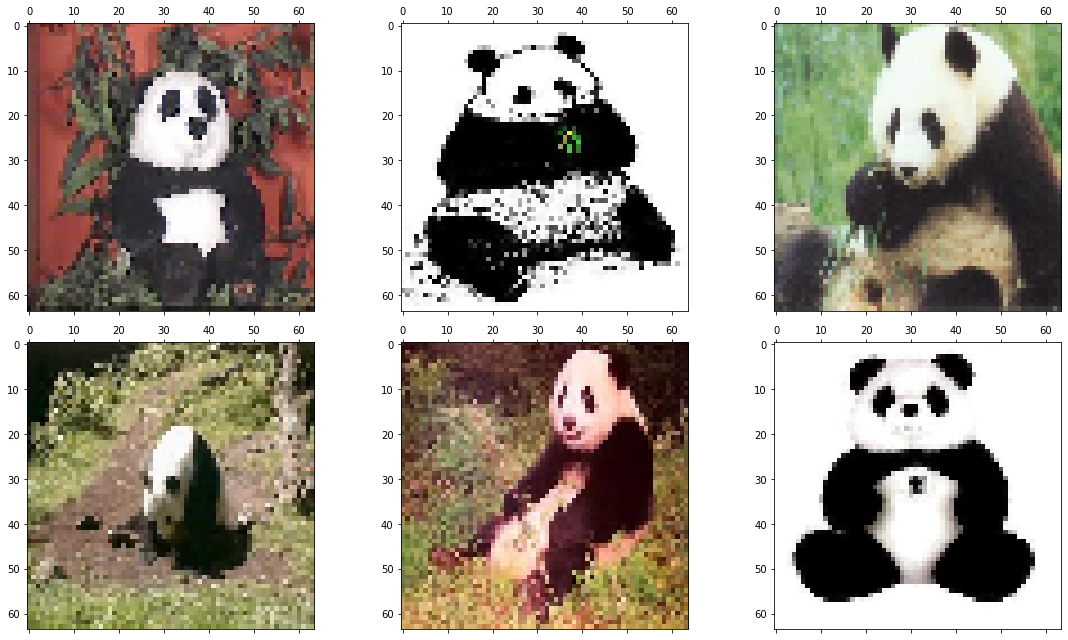

In [31]:
# Display images of 6 pandas in the training set (low resolution 64 x 64 pixels)
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,3):
        axs[i,j].matshow(X_train[n])
        n=n+1
plt.show() 

# let’s display a few high-res images that we will use as target images. Shape of Y_train: (30, 256, 256, 3)

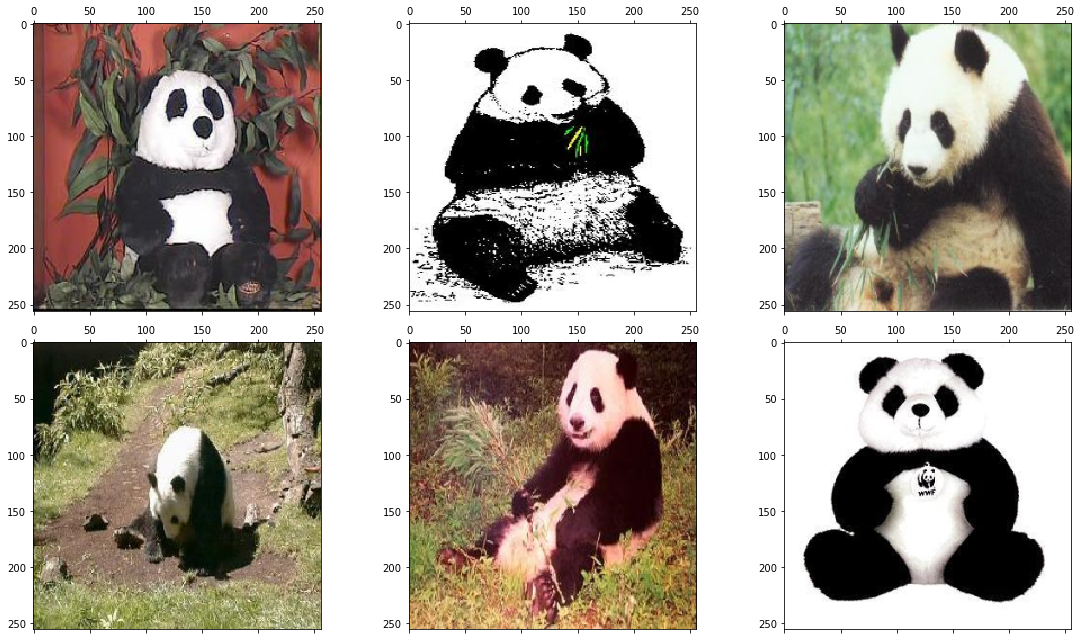

In [32]:
#Display images of 6 pandas in the test set (higher resolution 256 x 256 pixels)
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,3):
        axs[i,j].matshow(Y_train[n])
        n=n+1
plt.show() 

# Training and evaluating Transposed Convolutional Neural Network

This model is very simple, containing an Input layer, two Transposed Convolutional layers, and a final Convolutional layer that acts as Output. You can follow comments in the code to understand what each section does

In [33]:
X_train.shape

(30, 64, 64, 3)

In [34]:
#--- Define Shapes
input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]) # Specify input shape

In [35]:
#lower resolution. 
input_shape

(64, 64, 3)

In [36]:
#--- Input Layer 
inputs = Input(shape=input_shape, name='Input-Layer')

In [37]:
#Upsampling from 64x64 to 128x128 using the first Transposed Convolution.
d = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2,2), activation="relu", padding="same", name='Transpose-Conv2D-Layer-1')(inputs)
#Upsampling from 128x128 to 256*256 using the second Transposed Convolution.
d = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2,2), activation="relu", padding="same", name='Transpose-Conv2D-Layer-2')(d)
# Added Convolutional layer to bring the number of filters down to 3
# Default='valid', "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
outputs = Conv2D(filters=3, kernel_size=(3, 3), activation="sigmoid", padding="same", name='Output-Layer')(d)

In [38]:
#--- Assemble a model
model = Model(inputs, outputs, name='Transposed-Convolutional-NN')
model.compile(optimizer="adam", loss="mse", metrics=["Accuracy"])

In [39]:
#--- Print model summary
model.summary()

Model: "Transposed-Convolutional-NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 Transpose-Conv2D-Layer-1 (C  (None, 128, 128, 64)     832       
 onv2DTranspose)                                                 
                                                                 
 Transpose-Conv2D-Layer-2 (C  (None, 256, 256, 128)    32896     
 onv2DTranspose)                                                 
                                                                 
 Output-Layer (Conv2D)       (None, 256, 256, 3)       3459      
                                                                 
Total params: 37,187
Trainable params: 37,187
Non-trainable params: 0
_________________________________________________________________


# Checking the number of parameters. 

You can use this general formula:

channels_in * kernel_width * kernel_height * channels_out + num_channels

Transpose-Conv2D-Layer-1: 3 * 2 * 2 *64 + 64 = 832 Transpose-Conv2D-Layer-2: 64 * 2 *2 *128 +128 = 32896 Output-Layer (Conv2D): 128 * 3 *3 * 3 + 3 = 3459.

In [40]:
# Train Transpose Convolutional model
history = model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=1, validation_data=(X_test, Y_test), validation_freq=5)

Epoch 1/100
30/30 [==============================] - 13s 413ms/step - loss: 0.1051 - Accuracy: 0.4280
Epoch 2/100
30/30 [==============================] - 13s 423ms/step - loss: 0.0768 - Accuracy: 0.5873
Epoch 3/100
30/30 [==============================] - 12s 406ms/step - loss: 0.0632 - Accuracy: 0.5914
Epoch 4/100
30/30 [==============================] - 11s 380ms/step - loss: 0.0497 - Accuracy: 0.5707
Epoch 5/100
30/30 [==============================] - 13s 442ms/step - loss: 0.0327 - Accuracy: 0.5908 - val_loss: 0.0204 - val_Accuracy: 0.8189
Epoch 6/100
30/30 [==============================] - 12s 404ms/step - loss: 0.0233 - Accuracy: 0.4761
Epoch 7/100
30/30 [==============================] - 12s 396ms/step - loss: 0.0194 - Accuracy: 0.5921
Epoch 8/100
30/30 [==============================] - 12s 400ms/step - loss: 0.0174 - Accuracy: 0.5722
Epoch 9/100
30/30 [==============================] - 12s 409ms/step - loss: 0.0169 - Accuracy: 0.4931
Epoch 10/100
30/30 [====================

# Once training is complete, we can use the model to predict (upscale) low-res images to a higher resolution. Let’s look at a couple of examples, one from the training set and another from the test set.

In [41]:
# Take two images: one from train and another from test data
train_img_indx=6
test_img_indx=5
train_image=X_train[train_img_indx]
test_image=X_test[test_img_indx]

In [42]:
# The current shape of these image arrays are [rows, columns, channels].
# Add an extra dimension to make it [samples, rows, columns, channels] that is required by the model
train_image = train_image[np.newaxis, ...]
test_image = test_image[np.newaxis, ...]

In [43]:
# Use our Transpose Convolutional Model to upscale these images
train_img_upscale = model.predict(train_image)
test_img_upscale = model.predict(test_image)

In [44]:
train_img_upscale.shape, test_img_upscale.shape

((1, 256, 256, 3), (1, 256, 256, 3))

In [45]:
# Reshape data back from [samples, rows, columns, channels] to [rows, columns, channels] to show the images
train_img_upscale=train_img_upscale.reshape(256, 256, 3)
test_img_upscale=test_img_upscale.reshape(256, 256, 3)

# Display an image comparison from a training set:

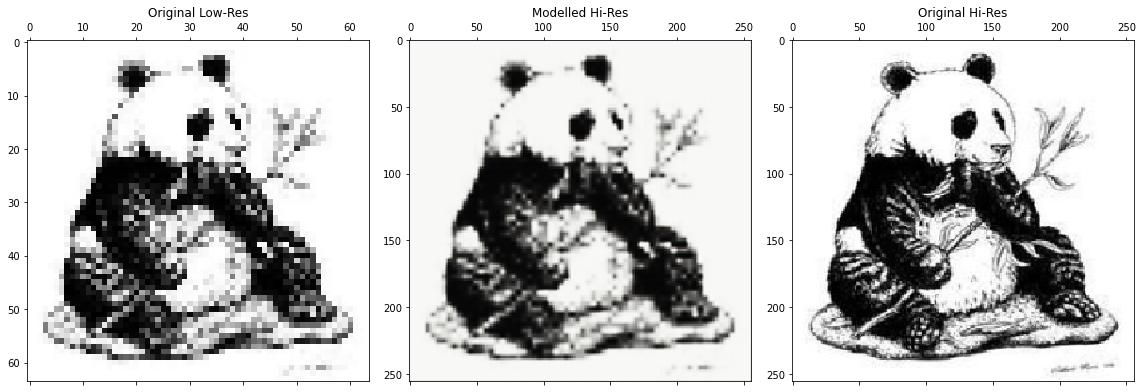

In [46]:
# Display image comparisons for train example
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs[0].matshow(X_train[train_img_indx])
axs[0].set(title='Original Low-Res')
axs[1].matshow(train_img_upscale)
axs[1].set(title='Modelled Hi-Res')
axs[2].matshow(Y_train[train_img_indx])
axs[2].set(title='Original Hi-Res')
plt.show() 

# Very good resolution compared to the original HI-Res!!

# Display an image comparison from a test set:

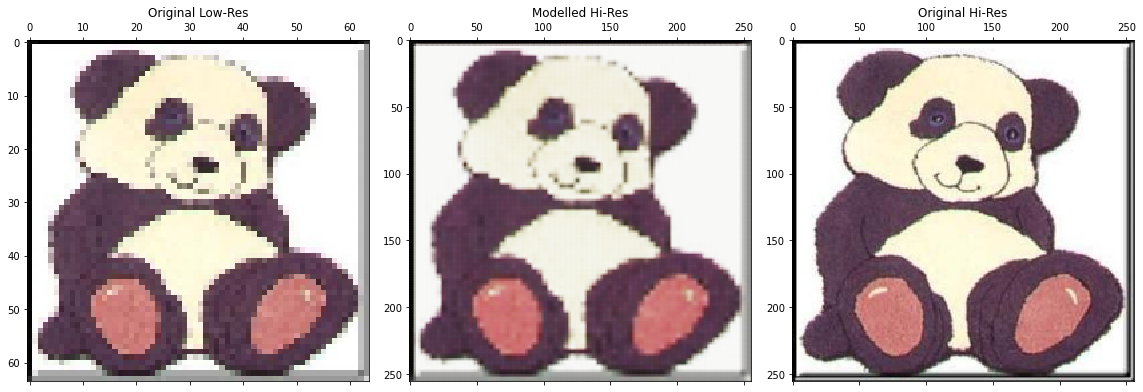

In [47]:
# Display image comparisons for test example
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs[0].matshow(X_test[test_img_indx])
axs[0].set(title='Original Low-Res')
axs[1].matshow(test_img_upscale)
axs[1].set(title='Modelled Hi-Res')
axs[2].matshow(Y_test[test_img_indx])
axs[2].set(title='Original Hi-Res')
plt.show() 

# Very good resolution compared to the original HI-Res! Testing comparison